### Numerical features performed much better than categorical ones (alone)
### Combining both produced almost the same as just numerical, or slightly better
### Need a way to cluster head of household category 

### TODO FEATURE ENGINEERING

### Adding income levels based on regions (sonia) average income level for each region in the training set
### for each household, add # of sd's they are away from the average income level in their region

### Groupings for grade: none, elementary, high school, bachelors, masters, program/trade school (sonia)

### Percentage of family employed (# employed / total family) + interaction between the two terms (sonia)

### (hans) the rest

### Total number of electronics
### Total number of motorized vehicles
### housing/water expenditure x toilet facility interaction
### Clustering types of jobs

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import normalize

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def select_features_from_lasso(X, y, alpha):
    # fit lasso model and pass to select from model
    Xtrain =normalize(X)
    lasso = Lasso(alpha).fit(Xtrain, y)
    model = SelectFromModel(lasso, prefit=True)

    # new features
    X_new = model.transform(X)
    return X.columns[model.get_support()]

In [4]:
def backward_stepwise(X, y):
    model = LinearRegression()

    vars_remaining = []
    vars_in_model = list(X.columns)
    
    last_error = cross_val_score(model, X[vars_in_model], y, cv=10, scoring="neg_mean_squared_error").mean()
    
    for _ in range(len(vars_in_model)):
        scores = []
        for var in vars_in_model:
            candidate_vars = copy.copy(vars_in_model)
            candidate_vars.remove(var)
            Xtrain = X[candidate_vars]
            scores.append(
                cross_val_score(model, normalize(Xtrain), y, cv=10, scoring="neg_mean_squared_error").mean()
            )
        i = np.argmax(scores)
        if scores[i] <= last_error:
            break
        else:
            last_error = scores[i]
            del vars_in_model[i]
            
    return vars_in_model

In [5]:
def forward_stepwise(X, y):
    model = LinearRegression()

    vars_remaining = list(X.columns)
    vars_in_model = []
    last_error = -np.inf

    for _ in range(len(vars_remaining)):
        scores = []
        for var in vars_remaining:
            candidate_vars = vars_in_model + [var]
            Xtrain = X[candidate_vars]
            scores.append(
                cross_val_score(model, normalize(Xtrain), y, cv=10, scoring="neg_mean_squared_error").mean()
            )
        i = np.argmax(scores)
        if scores[i] <= last_error:
            break
        else:
            last_error = scores[i]
            var_to_add = vars_remaining[i]
            vars_in_model.append(var_to_add)
            del vars_remaining[i]

    return vars_in_model

In [6]:
def get_categorical_numeric(df):
    numerics = []
    categorical = []

    for col in df:
        if((df[col].dtype == np.float64 or df[col].dtype == np.int64) and col != 'Unnamed: 0'):
            numerics.append(col)

        else:
            categorical.append(col)

    categorical_df = df[categorical]
    numeric_df = df[numerics]
    
    return categorical_df, numeric_df

In [7]:
def remove_categorical(X, feat, columns):
    for col in columns:
        if col in X:
            keep = []

            for f in feat:
                if col + '_' in f:
                    keep.append(f.replace(col + '_', ''))

            X[col][~(X[col].isin(keep))] = 'other'

In [117]:
""" 
 use lasso regression to select columns for the model
 try a range of alpha parameters on the lasso model
 mode can be just categorical, numerical, or both
"""
def train_lasso(alphas, mode):
    mse = []
    df = pd.read_csv('train.csv').dropna()
    y = df[['Total Household Income']] / 1e4
    df = df.drop(['Total Household Income', 'Unnamed: 0'], axis=1)
    
    for alpha in alphas:
        categorical_df, numeric_df = get_categorical_numeric(df)
        reg = LinearRegression()
        
        # only used categorical features
        # values not selected by lasso will be set to other
        if mode == "categorical":
            tmp = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            new_feat = select_features_from_lasso(tmp, y, alpha)
            remove_categorical(categorical_df, new_feat, categorical_df.columns)
            categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(new_feat)))
            
            print
            
            scores = cross_val_score(reg, categorical_df, y, cv=5, scoring='neg_mean_squared_error')
           
        # only use numerical features, and normalize the data
        elif mode == "numerical":
            new_feat = select_features_from_lasso(numeric_df, y, alpha)
            Xnum = preprocessing.scale(numeric_df[new_feat])
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(new_feat)))
            print (', '.join(new_feat))
            print
            
            scores = cross_val_score(reg, Xnum, y, cv=5, scoring='neg_mean_squared_error')
        
        # use both features
        else:
            new_feat = select_features_from_lasso(pd.get_dummies(categorical_df, categorical_df.columns), 
                y, alpha)
            remove_categorical(categorical_df, new_feat, categorical_df.columns)
            categorical_df = pd.get_dummies(categorical_df, columns = categorical_df.columns)
            
            new_feat = select_features_from_lasso(numeric_df, y, alpha)
            standardized = preprocessing.scale(numeric_df[new_feat])
            
            print ("Using alpha of {0} {1} columns were selected".format(alpha, len(categorical_df.columns) + 
                standardized.shape[1]))
            print
            
            total = np.concatenate((standardized, categorical_df.as_matrix()), axis=1)
            scores = cross_val_score(reg, total, y, cv=5, scoring='neg_mean_squared_error')

        print ("Alpha: {0}, MSE {1}".format(alpha, np.mean(scores)))
        print 

        mse.append(np.mean(scores))
        
    return mse

In [118]:
df = pd.read_csv('train.csv').dropna()
categorical_df, numeric_df = get_categorical_numeric(df)

In [119]:
assert len(df) == len(categorical_df) == len(numeric_df)
assert len(df.columns) == len(categorical_df.columns) + len(numeric_df.columns)

### Predict household income from just numerical features

In [120]:
X = numeric_df.drop(['Total Household Income'], axis=1)
y = numeric_df[['Total Household Income']] / 1e4 # predict income in tens of thousands of dollars

In [121]:
X.head()

,Total Food Expenditure,Agricultural Household indicator,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,81940,1,44171,40336,9053,4499,5245,6625,2410,145,...,0,1,0,0,0,2,0,0,0,0
1,26176,0,14477,13067,722,3707,755,1560,260,280,...,0,0,0,0,0,0,0,0,0,0
2,139920,0,31053,21720,12005,10415,1090,6355,65642,210,...,0,0,0,0,0,1,0,0,0,1
3,108931,0,41374,29008,12250,11840,1455,3551,22000,1350,...,0,1,0,0,0,2,0,1,0,0
4,61539,1,23758,19656,2496,12446,2448,5680,2540,0,...,0,1,0,0,0,1,0,0,0,1


### Use average household income to train regression model and produce a baseline MSE
### Very high baseline?

In [122]:
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=5, scoring='neg_mean_squared_error')
print ("Baseline MSE is {0}".format(np.mean(scores)))

Baseline MSE is -155.375664719


### Lasso  regression to select numerical features
### Normalize features first? (Increased MSE ...)
### Alpha = 1e-5 selected 28 columns and produced the best MSE

In [123]:
mse = train_lasso([1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1], "numerical")

Using alpha of 1e-06 39 columns were selected
Total Food Expenditure, Agricultural Household indicator, Bread and Cereals Expenditure, Total Rice Expenditure, Meat Expenditure, Total Fish and  marine products Expenditure, Fruit Expenditure, Vegetables Expenditure, Restaurant and hotels Expenditure, Alcoholic Beverages Expenditure, Tobacco Expenditure, Clothing, Footwear and Other Wear Expenditure, Housing and water Expenditure, Imputed House Rental Value, Medical Care Expenditure, Transportation Expenditure, Communication Expenditure, Education Expenditure, Miscellaneous Goods and Services Expenditure, Special Occasions Expenditure, Crop Farming and Gardening expenses, Total Income from Entrepreneurial Acitivites, Household Head Age, Total Number of Family members, Members with age 5 - 17 years old, Total number of family members employed, House Floor Area, House Age, Number of bedrooms, Electricity, Number of Television, Number of CD/VCD/DVD, Number of Refrigerator/Freezer, Number of 

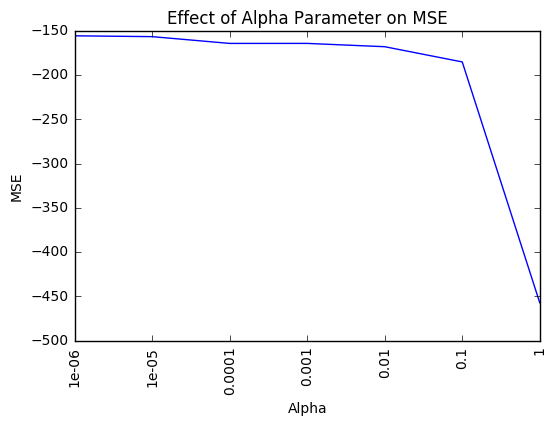

In [101]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()

### Backward stepwise did not take any columns

In [51]:
new_feat = backward_stepwise(X, y)
Xnew = normalize(X[new_feat])
reg = LinearRegression()
scores = cross_val_score(reg, Xnew, y, cv=5, scoring='neg_mean_squared_error').mean()
print "Using backward stepwise regression {0} columns were selected with an average MSE of {1}".format(len(new_feat), scores)

KeyboardInterrupt: 

### Forward stepwise selected 20 columns

In [16]:
new_feat = forward_stepwise(X, y)
Xnew = normalize(X[new_feat])
reg = LinearRegression()
scores = cross_val_score(reg, Xnew, y, cv=5, scoring='neg_mean_squared_error').mean()
print "Using forward stepwise regression {0} columns were selected with an average MSE of {1}".format(len(new_feat), scores)

KeyboardInterrupt: 

### Predict household income from just categorical features

In [17]:
X = categorical_df.drop(['Unnamed: 0'], axis = 1)
y = numeric_df[['Total Household Income']]

In [18]:
assert len(X) == len(categorical_df) == len(y)

### 500 columns after one-hot encoding and including all variables
### Household head occupation has 370 unique values (can probably be reduced)

In [19]:
X = pd.get_dummies(X, columns = X.columns)

In [20]:
X.head()

,Region_ ARMM,Region_CAR,Region_Caraga,Region_I - Ilocos Region,Region_II - Cagayan Valley,Region_III - Central Luzon,Region_IVA - CALABARZON,Region_IVB - MIMAROPA,Region_IX - Zasmboanga Peninsula,Region_NCR,...,"Main Source of Water Supply_Lake, river, rain and others",Main Source of Water Supply_Others,"Main Source of Water Supply_Own use, faucet, community water system","Main Source of Water Supply_Own use, tubed/piped deep well",Main Source of Water Supply_Peddler,"Main Source of Water Supply_Protected spring, river, stream, etc","Main Source of Water Supply_Shared, faucet, community water system","Main Source of Water Supply_Shared, tubed/piped deep well",Main Source of Water Supply_Tubed/piped shallow well,"Main Source of Water Supply_Unprotected spring, river, stream, etc"
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Alpha = 0.001 produced the best MSE and selected 107 columns
### For categorical variables, if the variable is chosen by lasso keep it, otherwise
### set it to an "other". Use the new dataframe in a linear regression model to
### get the mse

In [108]:
mse = train_lasso([1e-3, 1e-2, 0.1, 1],'categorical')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 0.001 233 columns were selected

Alpha: 0.001, MSE -3.27935240208e+22

Using alpha of 0.01 79 columns were selected

Alpha: 0.01, MSE -562.226935459

Using alpha of 0.1 18 columns were selected

Alpha: 0.1, MSE -631.673914687

Using alpha of 1 1 columns were selected

Alpha: 1, MSE -747.489725224



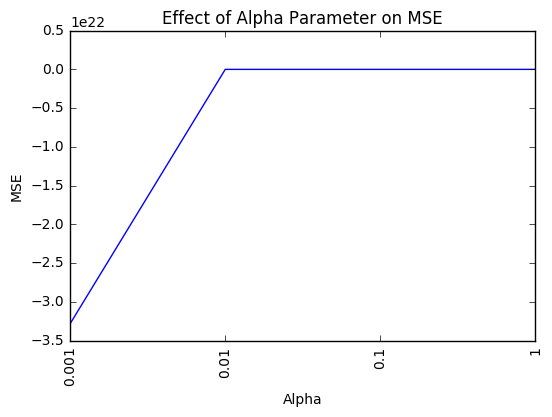

In [109]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-3, 1e-2, 0.1, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()

### Use all the features to compute the MSE

In [115]:
mse = train_lasso([1e-2, 0.1, 0.5, 1], 'both')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Using alpha of 0.01 112 columns were selected

Alpha: 0.01, MSE -154.480486003

Using alpha of 0.1 44 columns were selected

Alpha: 0.1, MSE -179.341379591

Using alpha of 0.5 22 columns were selected

Alpha: 0.5, MSE -359.404097672

Using alpha of 1 18 columns were selected

Alpha: 1, MSE -453.833778537



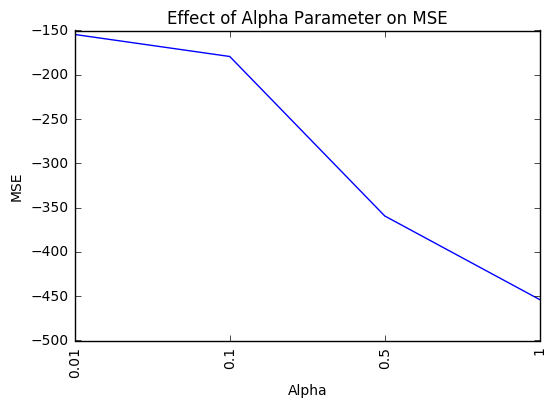

In [116]:
plt.plot(mse)
plt.xlabel('Alpha')
labels = [1e-2, 0.1, 0.5, 1]
plt.xticks(range(len(labels)), labels, rotation='vertical')
plt.ylabel('MSE')
plt.title('Effect of Alpha Parameter on MSE')
plt.show()